# Demo R8 Self-Attention

In this demo, we will analyze the equivariance properties of r8 group-equivariant self-attention models (i.e., to rotations by 45 degrees).

First, we will demonstrate the translation equivariance of the model and, subsequently, we will perform an analysis into the rotation equivariance properties of the model.

## Importing Libraries
Add the library to the system path via the relative folder structure:

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os,sys
g_selfatt_source =  os.path.join(os.getcwd(), '..')
if g_selfatt_source not in sys.path:
    sys.path.append(g_selfatt_source)

Import the necessary libraries:

In [11]:
# torch
import torch
import torch.nn as nn
# project
import g_selfatt
# other
from matplotlib import pyplot as plt
import importlib

## R8 Self-Attention Layers

In what follows we take:

* a random noise image f as input
* apply a sequence of r8 self-attention layers to it f -> N(f)
* translate the input (T(f)) via the action of the translation group on f and send it through the same sequence of layers and (T(f) -> N(T(f)))
* then we test the equivariance property T'(N(f))=N(T(f)) In the above T denotes the translation operator of 2D images, and T' denotes the translation operator on feature maps.

Subsequently, we repeat the process for rotations:

* apply a sequence of r8 self-attention layers to it f -> N(f)
* rotate the input (R(f)) via the action of the rotation group on f and send it through the same sequence of layers and (R(f) -> N(R(f)))
* then we test the equivariance property R'(N(f))=N(R(f)) In the above R denotes the rotation operator of 2D images, and R' denotes the rotation operator (shift-twist) of SE(2) images, which is a planar rotation and a periodic shift along the extra rotation axis.


Now, let us create a net with two self-attention layers, with a total of 3 ** 2 heads:

### The input feature map

In [12]:
Nxy = 15 # This spatial dimension
N_in = 10 # This many feature channels
B = 4 # Batch size
# For now we work with a placeholder
inputs = torch.randn([B,N_in,Nxy,Nxy], dtype=torch.float32)
inputs[:,:, :4, :] = 0.0 
inputs[:,:, :, :4] = 0.0 
inputs[:,:, -4:,:] = 0.0 
inputs[:,:, :, -4:] = 0.0 

### Attention Layers

In [13]:
# Layer parameters
num_heads = 3 ** 2

# Construct the group we want to test equivariance on.
num_elements = 8
group = g_selfatt.groups.SE2(num_elements)

# Construct the layers.
sa_1 = g_selfatt.nn.LiftLocalSelfAttention(
        group=group,
        in_channels=N_in,
        mid_channels=N_in,
        out_channels=N_in * 2,
        num_heads=num_heads,
        attention_dropout_rate=0.,
        patch_size=5)

sa_2 = g_selfatt.nn.GroupLocalSelfAttention(
    group=group,
        in_channels=N_in * 2, 
        mid_channels=N_in, 
        out_channels=N_in * 4,
        num_heads=num_heads,
        attention_dropout_rate=0,
        patch_size=5)
    

### Test the network - Translation Equivariance

We create random noise input and translated noise:

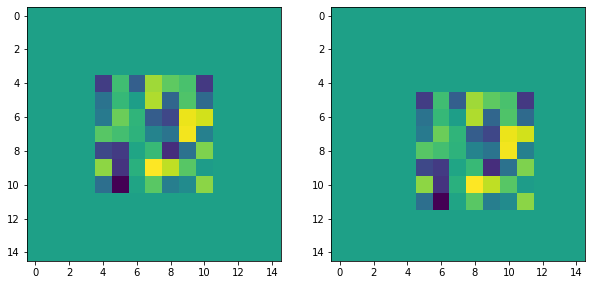

In [14]:
input_tensor = inputs
input_tensor_trans = torch.roll(inputs, (1,1), dims=(-2,-1))

f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1);plt.imshow(input_tensor.numpy()[0, 0,:, :])
plt.subplot(1,2,2);plt.imshow(input_tensor_trans.numpy()[0,0,:,:,])
plt.show()

Pass the original random signal to the network and then its translated version

In [15]:
out_1 = sa_1(input_tensor)
out_2 = sa_2(out_1)

out_1_trans = sa_1(input_tensor_trans)
out_2_trans = sa_2(out_1_trans)

Let's compare the results. Recall that now all feature maps are a funtion of the group. Thus it is composed of group.num_elements 'channels'.

FIRST LAYER:

The original input.


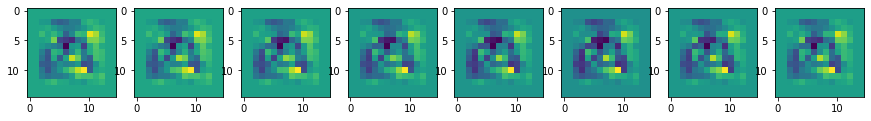

The translated input.


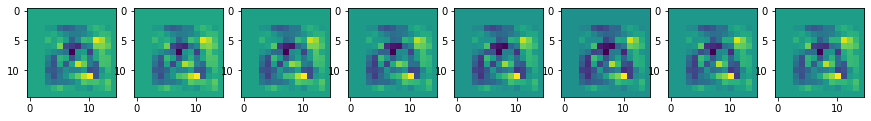


 SECOND LAYER:

The original input.


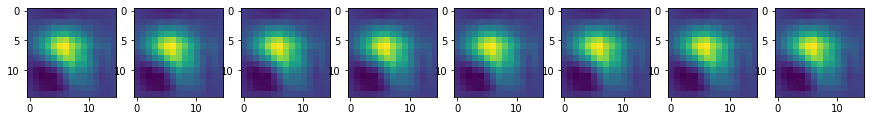

The translated input.


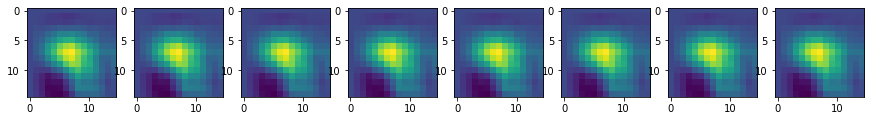

In [16]:
print('FIRST LAYER:\n')

print( 'The original input.')
plt.subplots(1,group.num_elements, figsize=(15,15))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1.detach().numpy()[0,0,i,:,:])
plt.show()

print( 'The translated input.')
plt.subplots(1,group.num_elements, figsize=(15,15))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1_trans.detach().numpy()[0,0,i,:,:])
plt.show()

print('\n SECOND LAYER:\n')

print( 'The original input.')
plt.subplots(1,group.num_elements, figsize=(15,15))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2.detach().numpy()[0,0,i,:,:])
plt.show()

print( 'The translated input.')
plt.subplots(1,group.num_elements, figsize=(15,15))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2_trans.detach().numpy()[0,0,i,:,:])
plt.show()

### Test the network - Rotation Equivariance

Now, let's analyze what occurs if the input image is rotated. Lets first see the input

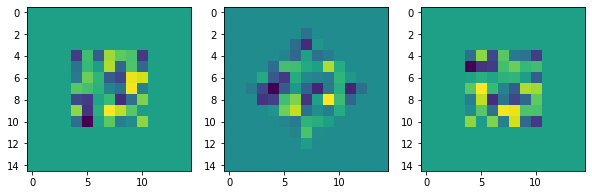

In [17]:
from scipy import ndimage 

angle_in_degrees = -45
input_tensor_45 = ndimage.rotate(inputs, angle_in_degrees, reshape=False, axes=(-1,-2), order=1)
#output = torch.from_numpy(output)

input_tensor = inputs
input_tensor_45 = torch.from_numpy(input_tensor_45)
input_tensor_90 = inputs.rot90(k=-1, dims=[-2,-1])

f,axs = plt.subplots(1,3,figsize=(10,10))
plt.subplot(1,3,1);plt.imshow(input_tensor.numpy()[0, 0,:, :])
plt.subplot(1,3,2);plt.imshow(input_tensor_45.numpy()[0, 0,:, :])
plt.subplot(1,3,3);plt.imshow(input_tensor_90.numpy()[0,0,:,:,]);
plt.show()

Pass the original random signal to the network and then its rotated version

In [18]:
out_1 = sa_1(input_tensor)
out_2 = sa_2(out_1)

out_1_45 = sa_1(input_tensor_45)
out_2_45 = sa_2(out_1_45)

out_1_90 = sa_1(input_tensor_90)
out_2_90 = sa_2(out_1_90)

Let's compare the results

FIRST LAYER:

The original input.


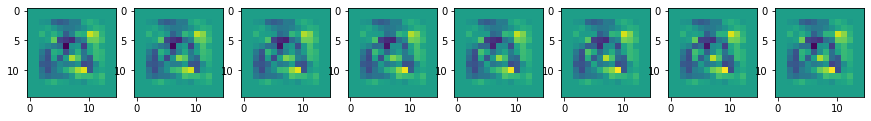

The 45 degrees rotated input.


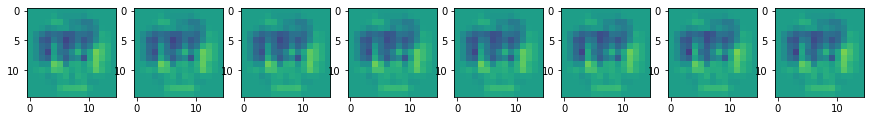

The 90 degrees rotated input.


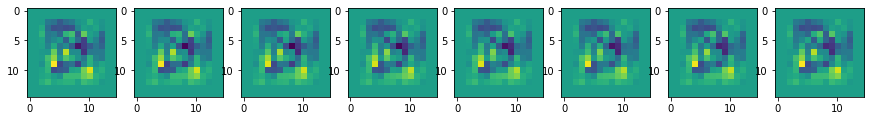


 SECOND LAYER:

The original input.


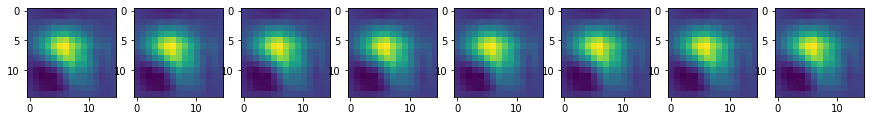

The 45 degrees rotated input.


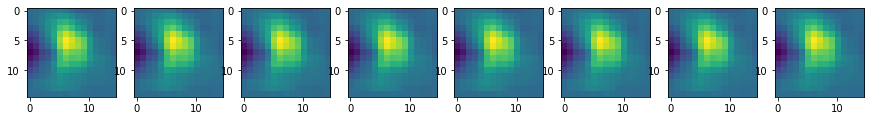

The rotated input.


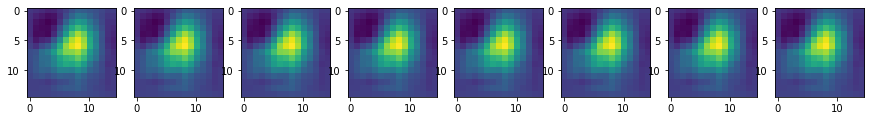

In [19]:
print('FIRST LAYER:\n')
vmax = max(torch.max(out_1[0,0,:,:,:]).item(), 
           torch.max(out_1_45[0,0,:,:,:]).item(), 
           torch.max(out_1_90[0,0,:,:,:]).item())
vmin = min(torch.min(out_1[0,0,:,:,:]).item(), 
           torch.min(out_1_45[0,0,:,:,:]).item(), 
           torch.min(out_1_90[0,0,:,:,:]).item())

print( 'The original input.')
plt.subplots(1,group.num_elements, figsize=(15,15))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.show()

print( 'The 45 degrees rotated input.')
plt.subplots(1,group.num_elements, figsize=(15,15))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1_45.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.show()

print( 'The 90 degrees rotated input.')
plt.subplots(1,group.num_elements, figsize=(15,15))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1_90.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.show()

print('\n SECOND LAYER:\n')
vmax = max(torch.max(out_2[0,0,:,:,:]).item(), 
           torch.max(out_2_45[0,0,:,:,:]).item(), 
           torch.max(out_2_90[0,0,:,:,:]).item())
vmin = min(torch.min(out_2[0,0,:,:,:]).item(), 
           torch.min(out_2_45[0,0,:,:,:]).item(), 
           torch.min(out_2_90[0,0,:,:,:]).item())

print( 'The original input.')

plt.subplots(1,group.num_elements, figsize=(15,15))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2.detach().numpy()[0,0,i,:,:]) #, vmin=vmin, vmax=vmax)
plt.show()

print( 'The 45 degrees rotated input.')
plt.subplots(1,group.num_elements, figsize=(15,15))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2_45.detach().numpy()[0,0,i,:,:]) #, vmin=vmin, vmax=vmax)
plt.show()

print( 'The rotated input.')
plt.subplots(1,group.num_elements, figsize=(15,15))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2_90.detach().numpy()[0,0,i,:,:])#, vmin=vmin, vmax=vmax)
plt.show()

As we can see, the responses are equivalent for rotated versions of the same image. Up to a permutation of the axes (1 to the right) and a rotation of each feature map (by a corresponding rotation to that of the input). 

The differences with the 45degree rotations come from the 

**DISCLAIMER!** Though the feat.maps look similar, they are not equal. To check this, look at the following example.

In [20]:
abs(out_1[0,0,0] - out_1[0,0,1]).max(), abs(out_1[0,0,0] - out_1[0,0,2]).max()

(tensor(0.0127, grad_fn=<MaxBackward1>),
 tensor(0.0232, grad_fn=<MaxBackward1>))

In [21]:
abs(out_1_90[0,0,2] - out_1_90[0,0,3]).max(), abs(out_1_90[0,0,2] - out_1_90[0,0,4]).max()

(tensor(0.0127, grad_fn=<MaxBackward1>),
 tensor(0.0232, grad_fn=<MaxBackward1>))

The max. value is different accross same channels but, for rotated versions, they are equal at the corresponding permuted channel locations.